# UMAP Segmentation for the Fluorscent Imaging

For image segmentation is a computational heavy task. Recommend to use GPU version of UMAP for fast output.

Key package dependency:
- [cuml](https://docs.rapids.ai/install)
- [umap](https://umap-learn.readthedocs.io/en/latest/index.html)
- [numba](https://numba.pydata.org/numba-doc/latest/index.html)
- [dask-cuda](https://docs.rapids.ai/api)

In [ ]:
# The dependency can be size up to >4GB. This step may take very long time, particular for libraft-distance, recommend to use mamba for quicker install
!mamba install -y -c rapidsai -c conda-forge -c nvidia cuml cudatoolkit numba umap-learn dask-cuda 

In [23]:
import os
from aicsimageio import AICSImage
import matplotlib.pyplot as plt

import dask
import dask.array as da
import dask.array.image
from dask.distributed import Client, progress, Scheduler, Worker, Nanny, SpecCluster
from dask_cuda import CUDAWorker
from dask_cuda.worker_spec import worker_spec
from dask_cuda.initialize import initialize
import psutil
import multiprocessing

from pprint import pprint
from xml.etree.ElementTree import ElementTree, Element
import json
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
import umap

import cuml
import cupy as cp

## Prepare Dask Cluster
We only have one GPU on the workstation, to speed up the CPU side process it is advise to setup heterogenous cluster.

In [2]:
# gather device info
cpu_count = multiprocessing.cpu_count()
memory_count = psutil.virtual_memory().total
print("CPU count:", cpu_count)
print("System memory:",memory_count)

CPU count: 16
System memory: 134746021888


In [3]:
specs = {
    "cpu":{
        "scale":3,
        "resources":{
        }
    },
    "gpu":{
        "scale":1,
        "resources":{
            "CUDA_VISIBLE_DEVICES": [0],
        }
    }
}

worker_count = 0
for v in specs.values():
    worker_count += v["scale"]

nthreads = cpu_count//worker_count
memory_limit = int(memory_count*0.9)//worker_count # set to use 90% of the system memory to avoid crashing

print("number of workers:", worker_count)
print("threads per worker:", nthreads)
print("memory limit per worker:", round(memory_limit/(1024*1024*1024),2), "GB")

number of workers: 4
threads per worker: 4
memory limit per worker: 28.24 GB


In [4]:
workers = {}

for k, v in specs.items():
    for i in range(v["scale"]):
        if "CUDA_VISIBLE_DEVICES" in v["resources"].keys():
            workers["{}-{}".format(k,i)] = worker_spec(
                threads_per_worker=nthreads, 
                CUDA_VISIBLE_DEVICES=v["resources"]["CUDA_VISIBLE_DEVICES"]
                )[0]
            workers["{}-{}".format(k,i)]["options"]["resources"]={"GPU":len(v["resources"]["CUDA_VISIBLE_DEVICES"])}
            workers["{}-{}".format(k,i)]["options"]["memory_limit"]=memory_limit
        else:
            workers["{}-{}".format(k,i)] = {
                "cls":Nanny,
                "options":{
                    "nthreads": nthreads,
                    "memory_limit": memory_limit
                    }
             }     
            
workers

2023-04-14 16:51:17,619 - distributed.comm.ucx - WARNING - A CUDA context for device 0 (b'GPU-bc766fff-879a-b990-efa4-76299e3e23aa') already exists on process ID 2554492. This is often the result of a CUDA-enabled library calling a CUDA runtime function before Dask-CUDA can spawn worker processes. Please make sure any such function calls don't happen at import time or in the global scope of a program.


{'cpu-0': {'cls': distributed.nanny.Nanny,
  'options': {'nthreads': 4, 'memory_limit': 30317854924}},
 'cpu-1': {'cls': distributed.nanny.Nanny,
  'options': {'nthreads': 4, 'memory_limit': 30317854924}},
 'cpu-2': {'cls': distributed.nanny.Nanny,
  'options': {'nthreads': 4, 'memory_limit': 30317854924}},
 'gpu-0': {'cls': distributed.nanny.Nanny,
  'options': {'env': {'CUDA_VISIBLE_DEVICES': '0'},
   'interface': None,
   'protocol': None,
   'nthreads': 4,
   'data': dict,
   'dashboard_address': ':8787',
   'plugins': [<dask_cuda.utils.CPUAffinity at 0x7f742a803eb0>],
   'silence_logs': True,
   'memory_limit': 30317854924,
   'preload': 'dask_cuda.initialize',
   'preload_argv': '--create-cuda-context',
   'resources': {'GPU': 1}}}}

In [8]:
scheduler = {'cls': Scheduler, 'options': {"dashboard_address": ':8787'}}
cluster = SpecCluster(scheduler=scheduler, workers=workers)
client = Client(cluster)
client

2023-04-14 16:51:42,699 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-04-14 16:51:42,723 - distributed.scheduler - INFO - State start
2023-04-14 16:51:42,727 - distributed.scheduler - INFO -   Scheduler at: tcp://129.67.90.167:36849
2023-04-14 16:51:42,728 - distributed.scheduler - INFO -   dashboard at:                     :8787
2023-04-14 16:51:42,743 - distributed.nanny - INFO -         Start Nanny at: 'tcp://129.67.90.167:35037'
2023-04-14 16:51:42,747 - distributed.nanny - INFO -         Start Nanny at: 'tcp://129.67.90.167:34849'
2023-04-14 16:51:42,751 - distributed.nanny - INFO -         Start Nanny at: 'tcp://129.67.90.167:45951'
2023-04-14 16:51:42,758 - distributed.nanny - INFO -         Start Nanny at: 'tcp://129.67.90.167:34003'
2023-04-14 16:51:43,029 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c5t470dt

<Client: 'tcp://129.67.90.167:36849' processes=4 threads=16, memory=112.94 GiB>

## Data Loading

For effective data loading, use [aicsimageio](https://github.com/AllenCellModeling/aicsimageio)

In [6]:
# idrive
# IMAGE_DATA = "/mnt/Imaging/Group Fritzsche/Jacky/myocardial cells/For sharing analysis/no097_FR_D30_Q2_lv2_CD31-AF555_PDGFRa-AF647_WGA-AF488.czi"

# kirpc541
IMAGE_DATA = "/home/jackyko/Jacky/data/mycardial_cells/no097_FR_D30_Q2_lv2_CD31-AF555_PDGFRa-AF647_WGA-AF488.czi"

In [7]:
img = AICSImage(IMAGE_DATA)
print(img.dims.order)  # T, C, Z, Y, X, (S optional)
img.dask_data

TCZYX


dask.array<transpose, shape=(1, 4, 1, 16720, 16749), dtype=uint16, chunksize=(1, 4, 1, 4096, 4096), chunktype=numpy.ndarray>

In [9]:
img.scenes

('ScanRegion0', 'ScanRegion1')

In [10]:
img.set_scene("ScanRegion0")

For faster display, we load the image with subsampling

In [11]:
SCALE = 10

In [12]:
img_dask_sub = img.dask_data[:,:,::SCALE,::SCALE,::SCALE]
img_dask_sub

dask.array<getitem, shape=(1, 4, 1, 1672, 1675), dtype=uint16, chunksize=(1, 4, 1, 410, 410), chunktype=numpy.ndarray>

## Channel Metadata

In [13]:
def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v
                     for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v)
                        for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
                d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d

In [14]:
META = img.metadata

In [15]:
d = etree_to_dict(META)

pprint(d)

{'ImageDocument': {'Metadata': {'AttachmentInfos': {'AttachmentInfo': {'@Id': 'Label:1',
                                                                       'Label': {'Barcodes': {'Barcode': {'@Id': 'Barcode:1',
                                                                                                          'Content': None,
                                                                                                          'Type': None}},
                                                                                 'OCRs': {'OCR': {'@Id': 'OCR:1',
                                                                                                  'Content': None}}},
                                                                       'Profile': {'IsProfileModified': 'True',
                                                                                   'ProfileName': 'REF_FL '
                                                                                        

In [16]:
# image information metadata
channel_info = d["ImageDocument"]["Metadata"]["Information"]["Image"]['Dimensions']['Channels']['Channel']
pprint(channel_info)


[{'@Id': 'Channel:0',
  '@Name': 'DAPI',
  'AcquisitionMode': 'WideField',
  'Color': '#FF00A0FF',
  'ComponentBitCount': '16',
  'ContrastMethod': 'Fluorescence',
  'CustomAttributes': {'MM.TotalMagnification': '20'},
  'DetectionWavelength': None,
  'DetectorSettings': {'Binning': '1,1',
                       'Detector': {'@Id': 'Detector:ORCA Flash'}},
  'DyeDatabaseId': '66071726-cbd4-4c41-b371-0a6eee4ae9c5',
  'DyeId': 'McNamara-Boswell-0434',
  'EmissionWavelength': '465',
  'ExcitationWavelength': '353',
  'ExposureTime': '5303600',
  'FilterSetRef': {'@Id': 'FilterSet:1'},
  'Fluor': 'DAPI',
  'IlluminationType': 'Epifluorescence',
  'IlluminationWavelength': {'Ranges': '370-400', 'SinglePeak': '385'},
  'LightSourcesSettings': {'LightSourceSettings': {'Intensity': '5.00 %',
                                                   'LightSource': {'@Id': 'LightSource:1'}}},
  'PixelType': 'Gray16'},
 {'@Id': 'Channel:1',
  '@Name': 'AF555',
  'AcquisitionMode': 'WideField',
  'Color'

## Display the Image

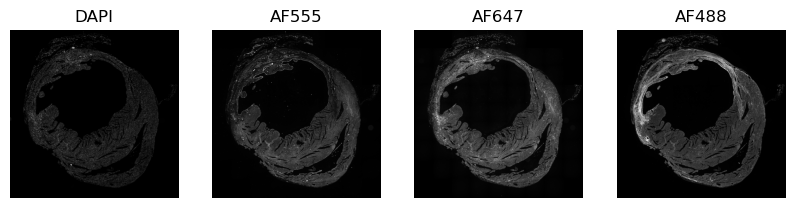

In [17]:
fig, axs = plt.subplots(1,4,figsize=(10,10))

for i in range(4):
    ax = axs[i]
    ax.set_axis_off()
    img_ch = img_dask_sub[0,i,0,]
    lp = da.percentile(img_ch.ravel(),0.5)
    up = da.percentile(img_ch.ravel(),99.5)
    ax.imshow(img_ch,cmap="gray",vmin=lp,vmax=up)
    ax.set_title(channel_info[i]['@Name'])

## Pixel Intensity Clustering for Region Identification, using UMAP

Convert the multi channel image to vector form before applying UMAP projection

In [18]:
input = img_dask_sub.T.reshape(-1,4)/255.0
input

# kmeans_multi = MiniBatchKMeans(4)
# kmeans_multi.fit(input)
# new_colors = kmeans_multi.cluster_centers_[kmeans_multi.predict(input)]

# # plot_pixels(input, colors=new_colors,title="Reduced color space: 3 colors")
# fig, axs = plt.subplots(1,4,figsize=(20,5))
# labels = kmeans_multi.labels_.reshape(images[1]['data'].shape[1:3])
# for i,ax in enumerate(axs):
#     ax.set_title("Region {}".format(i))
#     ax.imshow(labels==i,cmap="gray")
#     ax.set_axis_off()

dask.array<truediv, shape=(2800600, 4), dtype=float64, chunksize=(142120, 4), chunktype=numpy.ndarray>

### Normalize Input Data

In [20]:
%%time
# cpu version
scaled_input_data_cpu = StandardScaler().fit_transform(input)

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/dask/array/core.py:1711: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


CPU times: user 14.4 s, sys: 1.08 s, total: 15.5 s
Wall time: 31.4 s


It is advised to use all workers to transfer data to GPU, then perform calculation on single gpu worker.

In [25]:
%%time
input_gpu = cp.array(input)

CPU times: user 4.79 s, sys: 490 ms, total: 5.28 s
Wall time: 12.9 s


In [26]:
%%time
# gpu version
with dask.annotate(resources={'GPU': 1}):
    scaled_input_data_gpu = cuml.preprocessing.StandardScaler().fit_transform(input_gpu)

CPU times: user 236 ms, sys: 60.7 ms, total: 297 ms
Wall time: 278 ms


### CPU UMAP fitting

In [29]:
%%time
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    n_epochs=10,
    min_dist=0.1,    
    random_state=42
)

embedding_cpu = reducer.fit_transform(scaled_input_data, verbose=True)
embedding_cpu.shape

2023-04-14 17:12:13,938 - distributed.core - INFO - Event loop was unresponsive in Nanny for 10.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-04-14 17:12:13,984 - distributed.core - INFO - Event loop was unresponsive in Nanny for 10.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-04-14 17:12:13,985 - distributed.core - INFO - Event loop was unresponsive in Nanny for 10.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-04-14 17:12:13,986 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2023-04-14 17:12:13,987 - distributed.core - INFO - Event lo

In [ ]:
# df = pd.DataFrame(embedding, columns=('x', 'y'))
# df['class'] = pd.Series([str(x) for x in target], dtype="category")

# cvs = ds.Canvas(plot_width=400, plot_height=400)
# agg = cvs.points(df, 'x', 'y', ds.count_cat('class'))
# img = tf.shade(agg, color_key=color_key, how='eq_hist')

# utils.export_image(img, filename='fashion-mnist', background='black')

# image = plt.imread('fashion-mnist.png')
# fig, ax = plt.subplots(figsize=(12, 12))
# plt.imshow(image)
# plt.setp(ax, xticks=[], yticks=[])
# plt.title("Fashion MNIST data embedded\n"
#           "into two dimensions by UMAP\n"
#           "visualised with Datashader",
#           fontsize=12)

# plt.show()

In [ ]:
plt.scatter(
    embedding_cpu[:, 0],
    embedding_cpu[:, 1],
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the fluorescent intensity on CPU', fontsize=24)

### GPU UMAP fitting

In [ ]:
%%time
reducer = cuml.UMAP(
    n_neighbors=15,
    n_components=2,
    n_epochs=10,
    min_dist=0.1
)
embedding_gpu = reducer.fit_transform(scaled_input_data_gpu,verbose=True)

In [ ]:
# df_sample = df.sample(frac=0.25)
# fig, ax = plt.subplots(1, figsize=(14, 10))
# plt.scatter(
#     df_sample["x"].values, df_sample["y"].values, 
#     c=df_sample["class"].astype("int"), s=0.3, cmap='Spectral', alpha=1.0)
# plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# plt.title('Fashion MNIST Embedded via UMAP')

In [ ]:
plt.scatter(
    embedding_gpu[:, 0],
    embedding_gpu[:, 1],
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the fluorescent intensity on GPU', fontsize=24)

### Traditional Clustering
Follow the instruction of the UMAP documentation: https://umap-learn.readthedocs.io/en/latest/clustering.html#traditional-clustering